## Load Datasets

감정 분류 실습을 위해 허깅페이스 허브로부터 데이터셋 로딩

In [5]:
from datasets import load_dataset

emotions = load_dataset('emotion')

Generating train split: 100%|█| 16000/16000 [00:00<00:00, 1908182.32 examples/s]
Generating validation split: 100%|█| 2000/2000 [00:00<00:00, 836435.14 examples/
Generating test split: 100%|█████| 2000/2000 [00:00<00:00, 939900.06 examples/s]


## 학습 데이터셋, 검증 데이터셋, 테스트 데이터셋 분류

- 데이터셋 분류
- 데이터셋 생김새 출력
- 데이터셋 라벨 분포 시각화
- 감정 당 트윗 길이 분포 조사

In [12]:
train_ds, validation_ds, test_ds = emotions['train'], emotions['validation'], emotions['test']

print("학슴 데이터셋 크기: {}, 검증 데이터셋 크기: {}, 테스트 데이터셋 크기: {}".format(len(train_ds), len(validation_ds), len(test_ds)))

학슴 데이터셋 크기: 16000, 검증 데이터셋 크기: 2000, 테스트 데이터셋 크기: 2000


In [17]:
import pandas as pd

# Text, Label로 구성된 데이터셋임
print("Column names: {}".format(train_ds.column_names))

# Text는 dtype = string 이고, label 은 ClassLabel 이며 ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'] 순으로 라벨링 되어있음
print("Feature: {}".format(train_ds.features))

train_df = pd.DataFrame(train_ds)
train_df.head(10)

Column names: ['text', 'label']
Feature: {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [18]:
# Label을 string 으로 표현
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

train_df['label_name'] = train_df['label'].apply(label_int2str)
train_df.head(10)

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
5,ive been feeling a little burdened lately wasn...,0,sadness
6,ive been taking or milligrams or times recomme...,5,surprise
7,i feel as confused about life as a teenager or...,4,fear
8,i have been with petronas for years i feel tha...,1,joy
9,i feel romantic too,2,love


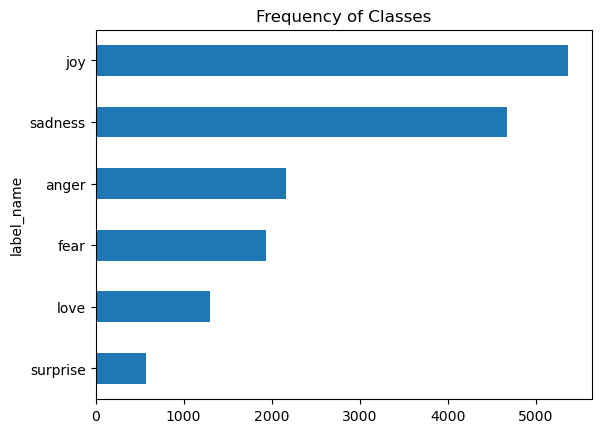

In [21]:
import matplotlib.pyplot as plt

train_df['label_name'].value_counts(ascending = True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

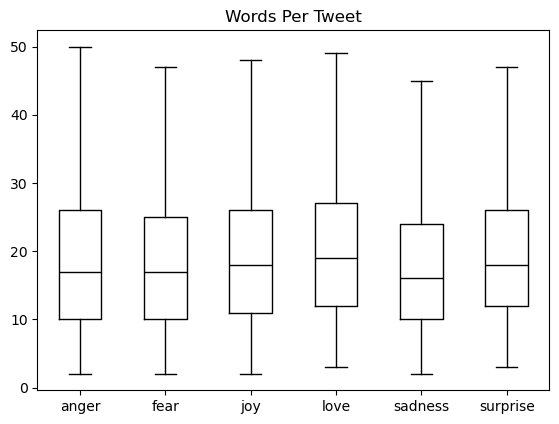

In [29]:
# Box Plot으로 감정 당 단어 수 표현
train_df["Words Per Tweet"] = train_df['text'].str.split().apply(len)
train_df.boxplot("Words Per Tweet", by = "label_name", grid = False, showfliers = False, color = 'black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## Text to Token
- DistilBERT 모델은 입력을 전통적 str로 받지 못함
- 따라서 토큰 임베딩을 통해 문자열을 토큰화 해야함

In [32]:
# tokenizer 임포트
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [33]:
text = "Tokenizing text is a core task of NLP"

encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [35]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']
[CLS] tokenizing text is a core task of nlp [SEP]


In [39]:
# tokenizer vocabs 사이즈
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [41]:
# 샘플을 토큰화할 함수 정의
# Padding = True => 최대 문맥 길이에 맞춰서 남은 자리를 0으로 패딩
# Truncation = True -> 최대 문맥 길이에 맞게 샘플을 잘라낸다
def tokenize(batch):
    return tokenizer(batch['text'], padding = True, truncation = True)

In [42]:
print(tokenize(train_ds[:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [46]:
# 토큰 인코딩 적용
emotions_encoded = emotions.map(tokenize, batched = True, batch_size=None)

In [45]:
print(emotions_encoded['train'].column_names)
print(emotions_encoded['train'][0])

['text', 'label', 'input_ids', 'attention_mask']
{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


## 텍스트 분류 모델 훈련하기

In [48]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [49]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 이동
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    # 마지막 은닉 상태를 추출
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # [CLS] 토큰에 대한 벡터를 반환
    return {"hidden_state" : last_hidden_state[:, 0].cpu().numpy()}

In [50]:
# torch 형태로 변환
emotions_encoded.set_format('torch', columns = ['input_ids', "attention_mask", "label"])

In [51]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched = True)

Map: 100%|██████████████████████████| 2000/2000 [00:05<00:00, 338.99 examples/s]


In [54]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']